In [24]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as snsme


from tqdm.notebook import tqdm
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import numpy as np

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm 
from torchvision.transforms import functional as TF

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torchmetrics import Dice, JaccardIndex
from collections import OrderedDict
import time
from skimage import exposure
import torchmetrics
import matplotlib.colors as mcolors
import scipy.ndimage as ndi
from skimage import measure
from matplotlib.patches import Patch
from skimage import measure, color
import matplotlib.patches as mpatches
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import ToTensor


!pip install albumentations==0.4.6

# plt.style.use("dark_background")

# Get & Prepare Data

In [25]:
class ImageMaskDataset(Dataset):
    """
    A dataset class for loading images and corresponding masks from directories.
    
    Args:
    - images_dir (str): Path to the directory with images.
    - masks_dir (str): Path to the directory with masks.
    - transform (callable, optional): Optional transform to be applied
        on a sample.
    """
    
    def __init__(self, images_dir, masks_dir, transform=None):
        # Store the directory paths for images and masks.
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        
        # Store the transform if provided.
        self.transform = transform
        
        # List all .png files in the images and masks directories.
        self.images = [file for file in sorted(os.listdir(images_dir)) if file.endswith('.tif')]
        self.masks = [file for file in sorted(os.listdir(masks_dir)) if file.endswith('.png')]
        
        # Create a list of full paths to the images for potential use in other operations.
        self.images_paths = [os.path.join(images_dir, img) for img in self.images]
        
    def __len__(self):
        # The total count of images and masks in the dataset.
        return len(self.images)

    def __getitem__(self, idx):
        # Instantiate the ToTensor transform
        to_tensor = ToTensor()
        
        # Construct the full path to the image and mask using the index (idx).
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        # Open the image file using PIL and convert to numpy array
        image = Image.open(img_path)
        image_np = np.array(image)
        
        # Convert the original image to tensor before applying transforms
        original_image = torch.from_numpy(image_np.astype(np.int64))

        # Open the mask file using PIL, convert to grayscale and to numpy array
        mask = Image.open(mask_path).convert('L')
        mask_np = np.array(mask, dtype=np.uint8)
        
        original_mask =  torch.from_numpy(mask_np.astype(np.int64))

        # If transformations are set, apply them to the image and mask.
        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image_np = augmented['image']
            mask_np = augmented['mask']
            replay = augmented['replay']
            

        # Add a channel dimension to the image and mask arrays if not already present.
        if image_np.ndim == 2:
            image_np = np.expand_dims(image_np, axis=0)
        if mask_np.ndim == 2:
            mask_np = np.expand_dims(mask_np, axis=0)

        # Threshold the mask to ensure it is binary (0 and 1).
        mask_np = (mask_np > 0).astype(np.int64)

        # Convert image and mask to PyTorch tensors.
        image = torch.from_numpy(image_np)
        mask = torch.from_numpy(mask_np).long()

        # Retrieve the path for the current image.
        image_path = self.images_paths[idx]

        # Return the image, mask, and image path.
        return original_image, original_mask, image, mask, image_path, replay



In [26]:
# Custom CLAHE function using skimage
def apply_clahe(image, clip_limit=0.5, **kwargs):
    image_float = image.astype(np.float32)

    # Apply CLAHE
    image_clahe = exposure.equalize_adapthist(image_float, clip_limit=clip_limit)

    # Return the image in float32 and normalized range [0, 1]
    return image_clahe.astype(np.float32)


In [27]:
# Geometric Transforms
transforms_geometric = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=45, p=0.25),
])

# Pixel-wise Transforms
transforms_pixelwise = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.GaussNoise(var_limit=5, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30, p=0.5),
])

# Advanced Geometric Transforms
transforms_advanced = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.25),
    A.GridDistortion(p=0.25),
    A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.25),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.25),
])

# DeepSea Transforms
transforms_deepsea = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.CLAHE(clip_limit=4.0, p=1),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
])

# Combined Transforms
transforms_combined = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.75),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.25),
    A.GridDistortion(p=0.25),
    A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.25),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
])

# Pixel-wise Transforms
transforms_pixelwise = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.GaussNoise(var_limit=5, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30, p=0.5),
])

# Advanced Geometric Transforms
transforms_advanced = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.25),
    A.GridDistortion(p=0.25),
    A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.25),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.25),
])

# DeepSea Transforms
transforms_deepsea = A.ReplayCompose([
    A.ToFloat(max_value=65535.0),
    A.Resize(height=512, width=512),
    A.Lambda(image=apply_clahe, name='apply_clahe'),
    A.GaussNoise(var_limit=(0.005, 0.005), p=1),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
])



# Combined Transforms
transforms_combined = A.ReplayCompose([
    A.Resize(height=512, width=512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.75),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.25),
    A.GridDistortion(p=0.25),
    A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.25),
    A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
])


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout


In [28]:
def custom_collate_fn(batch):
    return tuple(zip(*batch))

# Instantiate the training dataset with corrected paths
train_dataset = ImageMaskDataset(
    images_dir='/kaggle/input/tif-images-masks/images .tiff',
    masks_dir='/kaggle/input/tif-images-masks/masks',
    transform = transforms_deepsea
)

# Assuming you have an array of indices to split, e.g., np.arange(len(train_dataset))
indices = np.arange(len(train_dataset))

# Split indices into train and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Creating PyTorch datasets for train and validation, ensuring transforms are applied
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

# Create dataloaders for train and validation sets with the transforms_deepsea applied
train_dataloader = DataLoader(train_subset, batch_size=4, num_workers=2, shuffle=True, collate_fn=custom_collate_fn)
validation_dataloader = DataLoader(val_subset, batch_size=4, num_workers=2, shuffle=False, collate_fn=custom_collate_fn)


/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  state.update(self.get_transform_init_args())
/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  state.update(self.get_transform_init_args())


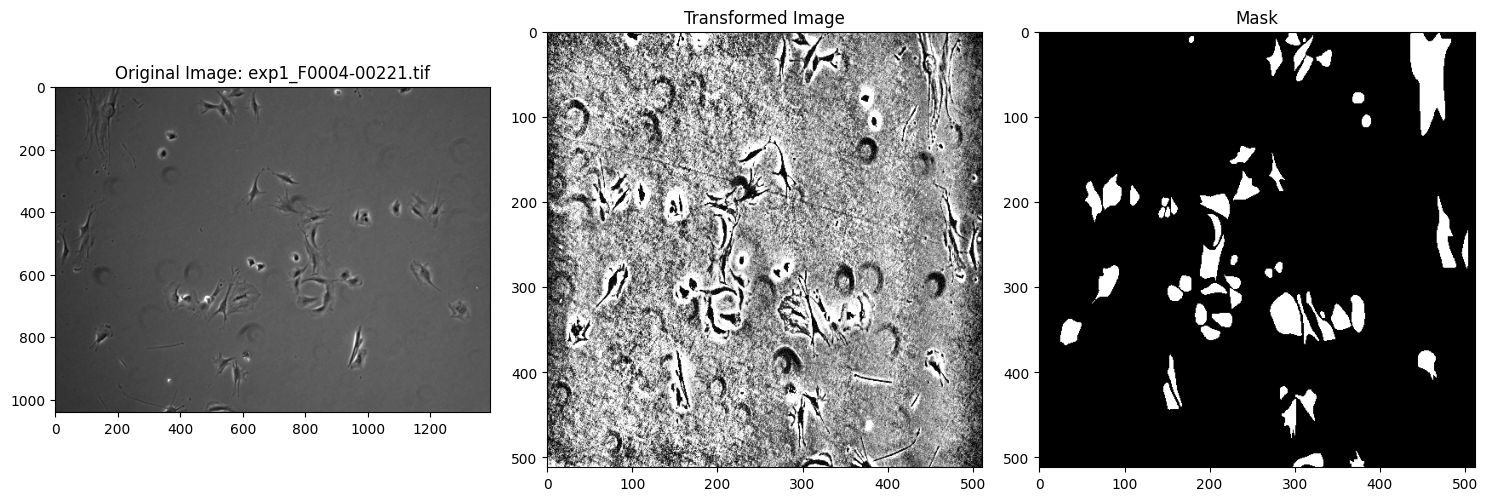

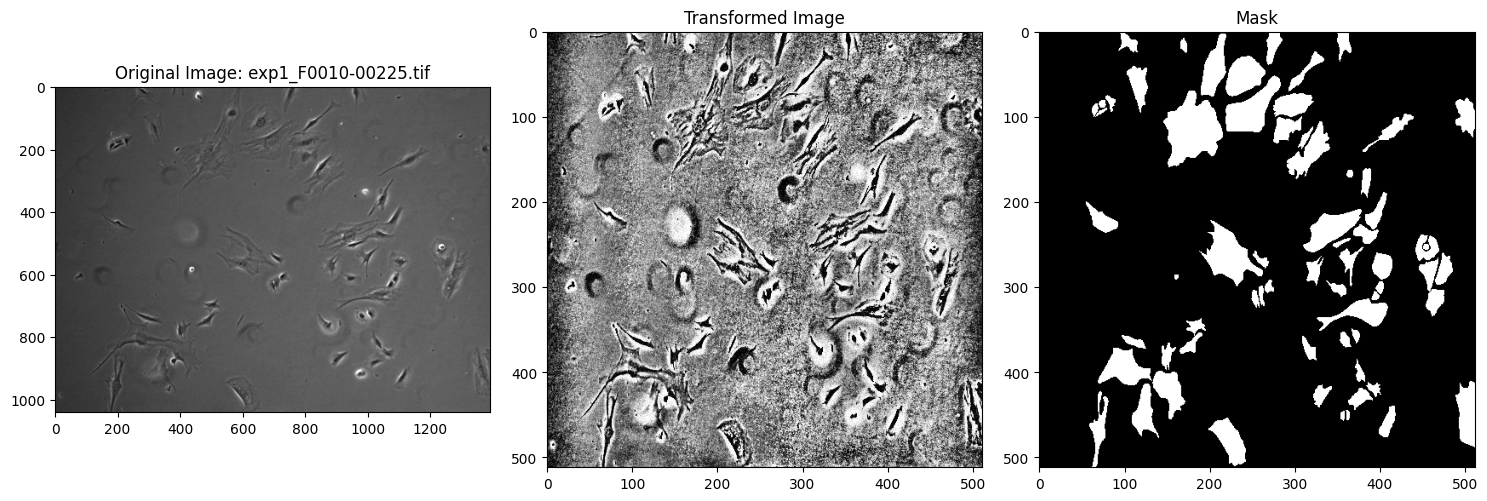

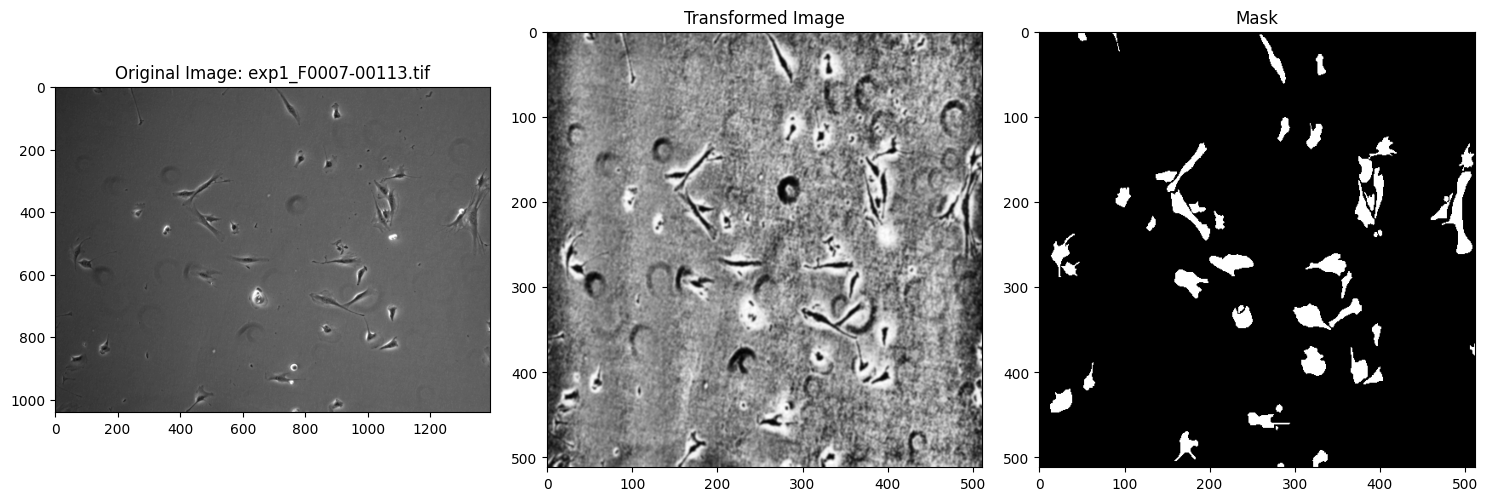

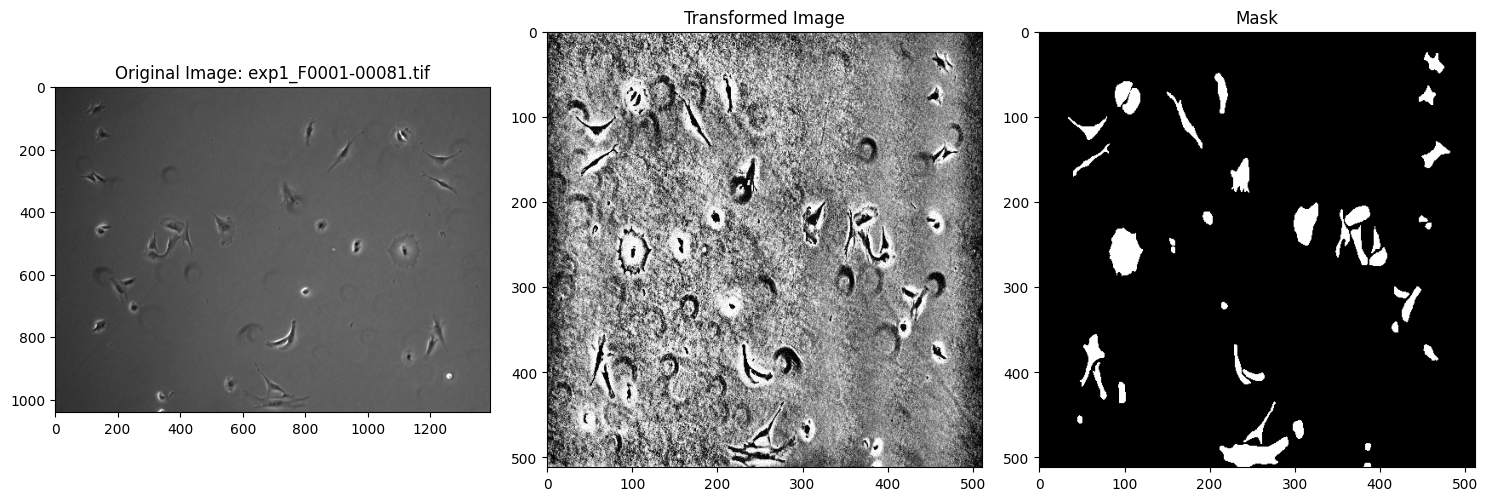

In [29]:
# Function to visualize a single example
def visualize(original_image, transformed_image, mask, image_name):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Display original image
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image: ' + image_name)

    # Ensure the transformed image is squeezed properly
    transformed_image = transformed_image.squeeze()

    # Display transformed image
    ax[1].imshow(transformed_image, cmap='gray')
    ax[1].set_title('Transformed Image')

    # Display mask
    mask = mask.squeeze()
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title('Mask')

    plt.tight_layout()
    plt.show()

# Initialize a counter
visualized_count = 0

# Retrieve a batch of images, masks, and paths from the dataloader
for batch in train_dataloader:
    
    _, _,images, masks, image_paths, _ = batch


    for i in range(len(images)):
        # Break out of the loop if 4 images have been visualized
        if visualized_count >= 4:
            break

        original_image_path = image_paths[i]
        original_image = Image.open(original_image_path)  # Open the image
        original_image_np = np.array(original_image)

        # Normalize the original image if it's uint16
        if original_image_np.dtype == np.uint16:
            original_image_np = original_image_np / 65535.0

        # Ensure the transformed image is a numpy array
        transformed_image = images[i].detach().cpu().numpy()

        # Check and normalize the transformed image if necessary
        if transformed_image.dtype == np.uint16:
            transformed_image = transformed_image / 65535.0

        mask = masks[i].detach().cpu().numpy()
        image_name = os.path.basename(original_image_path)

        visualize(original_image_np, transformed_image, mask, image_name)

        # Increment the counter
        visualized_count += 1

    # Break out of the outer loop if 4 images have been visualized
    if visualized_count >= 4:
        break


In [30]:
# batch = next(iter(train_dataloader))
# print(batch)
batch = next(iter(train_dataloader))
print(batch[0][0])


/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  state.update(self.get_transform_init_args())
/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  state.update(self.get_transform_init_args())


tensor([[1409, 1345, 1387,  ..., 1780, 1773, 1868],
        [1320, 1371, 1363,  ..., 1836, 1852, 1828],
        [1407, 1356, 1345,  ..., 1808, 1835, 1801],
        ...,
        [1548, 1601, 1680,  ..., 2023, 2005, 2025],
        [1574, 1601, 1606,  ..., 2007, 1991, 2028],
        [1617, 1645, 1616,  ..., 2033, 2005, 2029]])


# Attention U-Net

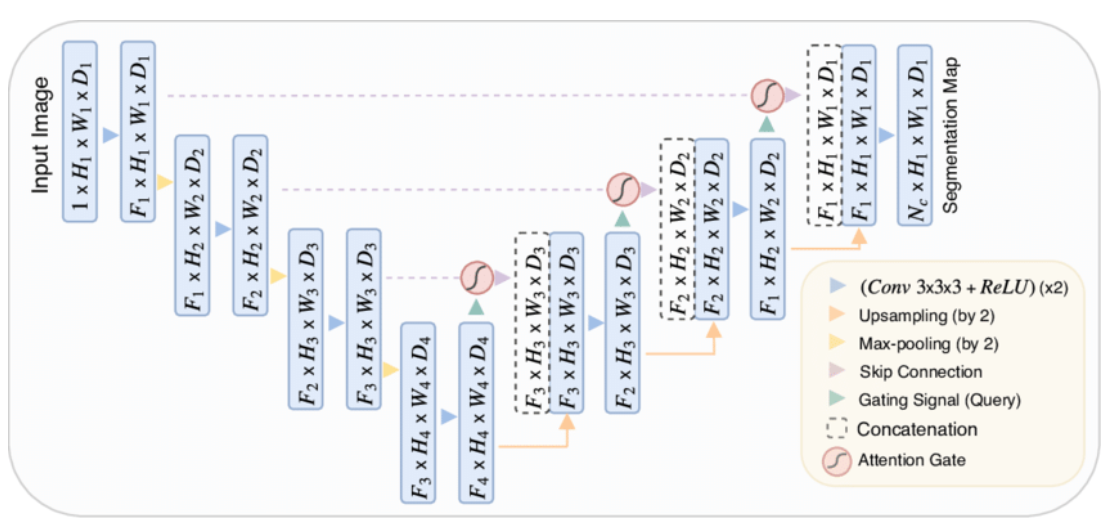



## Model Blocks

In [31]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [32]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [33]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

## Model

In [34]:
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=1, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1)
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        
        return d1

# Segmentation Metric

In [ ]:
# For the training data loader
for data, target, _ in train_dataloader:
    print(f"Data device: {data.device}")
    print(f"Target device: {target.device}")
    break  # Only check the first batch

# For the validation data loader
for data, target, _ in validation_dataloader:
    print(f"Data device: {data.device}")
    print(f"Target device: {target.device}")
    break  # Only check the first batch




# Segmentation Loss

## Summary of Loss Function Selection for Cell Segmentation in Deep Neural Networks

- **Importance**: Selecting an appropriate loss function is crucial for training deep neural networks in cell segmentation tasks.
- **Categories**: Loss functions in semantic segmentation are generally categorized into:
  1. **Distribution-based**: These aim to minimize dissimilarity between probability distributions and control intra-class imbalance but may underperform with inter-class imbalance.
  2. **Region-based**: These focus on minimizing mismatch/maximizing overlap between actual and predicted segmentation, suitable for inter-class imbalance but not as effective for the false positives/negatives trade-off.
  3. **Boundary-based**: A newer category that minimizes distance between actual and predicted segmentation considering shape, solving inter-class imbalance but potentially leading to training difficulties due to their non-convex nature.
  4. **Compounded loss functions**: These combine various loss function types to leverage their respective advantages.

- **Challenges in Biomedical Imaging**:
  - Current research on loss functions for biomedical imaging has been largely centered on segmenting small objects against a large background, mainly addressing inter-class imbalance.
  - For microscopy cell segmentation, the challenge extends beyond inter-class imbalance to intra-class imbalance, segmentation of cell details, and handling missing annotations.


In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [35]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        # Convert inputs to probabilities
        inputs = torch.sigmoid(inputs)
        
        # Ensure targets are the same data type as inputs
        targets = targets.float()
        
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


In [36]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha if alpha is not None else 1.0  # Set alpha to 1.0 if it's None
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs, targets = inputs.float(), targets.float()  # Ensure both are float
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss



In [ ]:
class CombinedFocalDiceLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.8, reduction='mean'):
        super(CombinedFocalDiceLoss, self).__init__()
        self.focal_loss = FocalLoss(gamma=gamma, reduction=reduction)
        self.alpha = alpha

    def dice_loss(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Apply sigmoid to get [0,1] probabilities
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

    def forward(self, inputs, targets):
        # Ensure both inputs and targets are float
        inputs, targets = inputs.float(), targets.float()

        focal_loss = self.focal_loss(inputs, targets)
        dice_loss = self.dice_loss(inputs, targets)
        combined_loss = self.alpha * focal_loss + (1 - self.alpha) * dice_loss
        return combined_loss


In [37]:
# sanity check
DiceLoss()(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1419)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# FocalLoss and CombinedFocalDiceLoss classes as you provided

# Initialize the loss functions
focal_loss = FocalLoss()
combined_loss = CombinedFocalDiceLoss()

# Sample inputs and targets
inputs = torch.tensor([0.7, 1., 1.], requires_grad=True)
targets = torch.tensor([1., 1., 1.])

# Calculate losses
focal_loss_value = focal_loss(inputs, targets)
combined_loss_value = combined_loss(inputs, targets)

print("Focal Loss:", focal_loss_value.item())
print("Combined Focal Dice Loss:", combined_loss_value.item())


# Training

In [38]:
def visualize_predictions(loader, model, device, num_images=5, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    batch = next(iter(loader))  # Get a batch of images, targets, and image paths
    
    # Unpack the batch
    _, _, images_tuple, targets_tuple, image_paths, _ = batch
    # Convert tuples of images and targets to lists and then stack to create batch tensors
    images = torch.stack([image.to(device) for image in images_tuple])
    targets = torch.stack([target.to(device) for target in targets_tuple])

    with torch.no_grad():  # No gradient is needed for visualization
        outputs = model(images)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to convert to probabilities
        outputs = outputs > threshold  # Apply threshold to get binary mask
        outputs = outputs.float()  # Convert boolean tensor to float for visualization

    # Determine the number of images to visualize, which should not exceed the batch size
    num_images = min(num_images, images.shape[0])

    plt.figure(figsize=(15, num_images * 5))  # Adjust the figure size appropriately

    for i in range(num_images):
        image_np = images[i].cpu().squeeze().numpy()
        target_np = targets[i].cpu().squeeze().numpy()
        output_np = outputs[i].cpu().squeeze().numpy()  # Convert to numpy for visualization
        image_name = os.path.basename(image_paths[i])  # Extract the image name from the path

        # Original Image with title including the image name
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.title(f'Original Image: {image_name}')
        plt.imshow(image_np, cmap='gray')
        plt.axis('off')

        # True Mask
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.title(f'True Mask: {image_name}')
        plt.imshow(target_np, cmap='gray')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.title(f'Predicted Mask: {image_name}')
        plt.imshow(output_np, cmap='gray')
        plt.axis('off')

    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()  # Display the plot

In [ ]:
import torch
from torchmetrics import Dice, JaccardIndex
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ExponentialLR

# Training function
def train_model(model_name, model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, save_path):
    print(f"[INFO] Starting training: {model_name}")
    
    # Setup for using multiple GPUs if available
    if torch.cuda.device_count() > 1:
        print(f"Let's use {torch.cuda.device_count()} GPUs!")
        model = torch.nn.DataParallel(model)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize metrics for binary segmentation
    dice_metric = Dice().to(device)
    jaccard_metric = JaccardIndex(task="binary", num_classes=2).to(device)
    
    # Lists for tracking losses and learning rates
    loss_history, train_dice_history, val_jaccard_history = [], [], []
    learning_rate_history = []
    
    # Training and validation loss and score tracking
    total_train_loss = []
    total_train_score = []
    total_valid_loss = []
    total_valid_score = []

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_loss = []
        train_score = []
        for data, target, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss_value = loss.item()
            score = jaccard_metric(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss_value)
            train_score.append(score.item())
            
            # Scheduler step after each batch and record the learning rate
            scheduler.step()
            learning_rate_history.append(optimizer.param_groups[0]['lr'])


        total_train_loss.append(np.mean(train_loss))
        total_train_score.append(np.mean(train_score))

        # Validation Phase
        model.eval()
        valid_loss = []
        valid_score = []
        with torch.no_grad():
            for image, mask, _ in val_loader:
                image, mask = image.to(device), mask.to(device)
                output = model(image)
                loss = criterion(output, mask)
                loss_value = loss.item()
                score = jaccard_metric(output, mask)
                valid_loss.append(loss_value)
                valid_score.append(score.item())

        total_valid_loss.append(np.mean(valid_loss))
        total_valid_score.append(np.mean(valid_score))

        # Print statistics including the current learning rate
        print(f"Epoch {epoch+1}/{num_epochs} finished: LR: {learning_rate_history[-1]:.6f}, Train Loss: {total_train_loss[-1]:.4f}, Train IoU: {total_train_score[-1]:.4f}, Valid Loss: {total_valid_loss[-1]:.4f}, Valid IoU: {total_valid_score[-1]:.4f}")

        # Save the model's state_dict after every 5 epochs
        if (epoch + 1) % 5 == 0:
            unique_save_path = f"{save_path}_{model_name}_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), unique_save_path)
            print(f"[INFO] Model weights saved to {unique_save_path}")

    return total_train_loss, total_train_score, total_valid_loss, total_valid_score, learning_rate_history


In [39]:
# Instantiate the model
attention_unet = AttentionUNet(n_classes=1, in_channel=1, out_channel=1)

# Define the path to the pre-initialized weights
pretrained_weights_path = '/kaggle/input/focal-loss/attention_unet_model.pth_Attention UNet_final_epoch150_FocallLoss.pth'

# Load the pre-initialized weights
attention_unet.load_state_dict(torch.load(pretrained_weights_path))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_unet.to(device)

# Initialize the optimizer with the model parameters
optimizer = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

# Define the number of epochs and the model save path
num_epochs = 50
model_save_path = '/kaggle/working/attention_unet_model.pth'

# Define your loss function (assuming FocalLoss is already defined)
loss_function = FocalLoss()

# Initialize the Exponential learning rate scheduler
lr_scheduler = CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-2, 
                     step_size_up=5, step_size_down=20, 
                     mode='triangular', cycle_momentum=False)


In [ ]:
# Call the train_model function with the necessary parameters
aun_tl, aun_ts, aun_vl, aun_vs, lr_history = train_model(
    model_name="Attention UNet",
    model=attention_unet,
    train_loader=train_dataloader,  
    val_loader=validation_dataloader,  
    criterion=loss_function,
    optimizer=optimizer,
    scheduler=lr_scheduler, 
    num_epochs=num_epochs,
    save_path=model_save_path
)

In [ ]:
# Convert the data to pandas DataFrames
train_data = pd.DataFrame({
    'Training Loss': aun_tl, 
    'Training IoU': aun_ts
})

validation_data = pd.DataFrame({
    'Validation Loss': aun_vl, 
    'Validation IoU': aun_vs
})

# Add learning rate history
learning_rate_data = pd.DataFrame({
    'Learning Rate': lr_history
})

# Concatenate training, validation data, and learning rate data side by side
combined_data = pd.concat([train_data, validation_data, learning_rate_data], axis=1)

# Add a column for epochs
combined_data.insert(0, 'Epoch', range(1, len(combined_data) + 1))

# Create a Pandas Excel writer using the ExcelWriter function
with pd.ExcelWriter('/kaggle/working/model_performance_data.xlsx') as writer:
    # Write the combined DataFrame to a single sheet
    combined_data.to_excel(writer, sheet_name='Model Performance Data', index=False)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(lr_history)
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule Over Batches')
plt.show()

/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  state.update(self.get_transform_init_args())
/opt/conda/lib/python3.10/site-packages/albumentations/core/transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  state.update(self.get_transform_init_args())


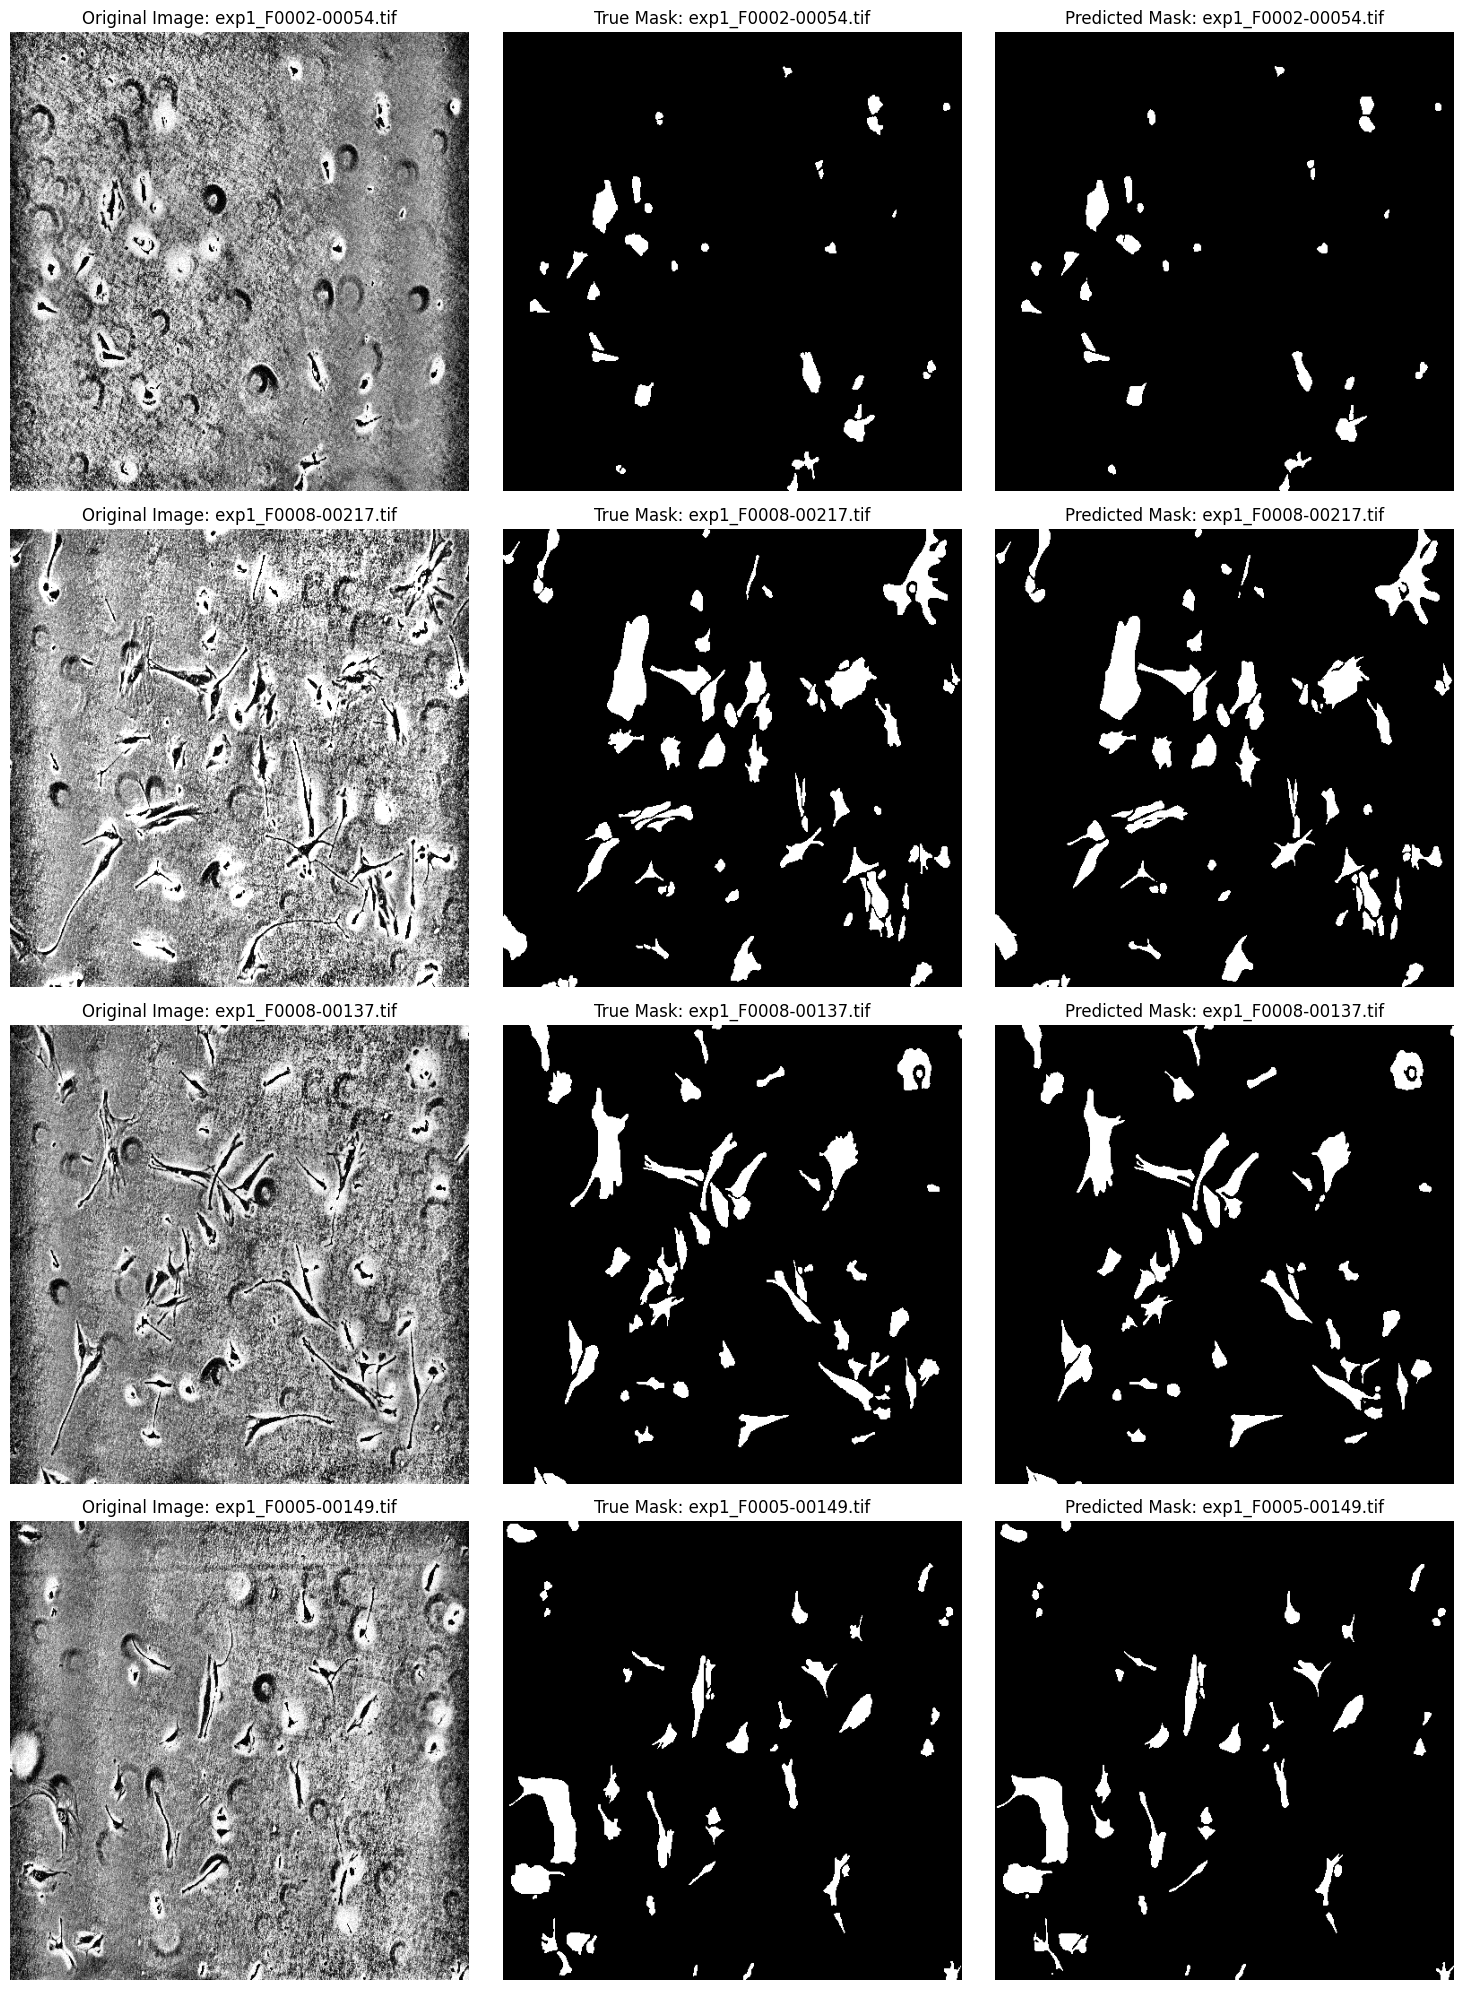

In [40]:
def remove_module_prefix(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():  
        name = k.replace('module.', '')  
        new_state_dict[name] = v
    return new_state_dict

def load_model(model_path):
    # Initialize your model
    model = AttentionUNet()  

    # Load the state dict from the file
    state_dict = torch.load(model_path)

    # Remove 'module.' prefix if present
    state_dict = remove_module_prefix(state_dict)

    # Load the state dict into the model
    model.load_state_dict(state_dict)

    return model

# Define the path to your model weights file
model_weights_path = "/kaggle/input/focal-loss/attention_unet_model.pth_Attention UNet_final_epoch150_FocallLoss.pth"

# Load your trained model
model = load_model(model_weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the same device as the input data
model.to(device)

# Now you can call visualize_predictions
visualize_predictions(validation_dataloader, model, device, num_images=5, threshold=0.5)



In [119]:
original_images, original_masks,images_tuple, targets_tuple, image_paths, replay = batch

# Convert tuples of images and targets to lists and then stack to create batch tensors
images = images_tuple[0].to(device)
targets = targets_tuple[0].to(device)

print(images)

tensor([[[0.0588, 0.0644, 0.0799,  ..., 0.2413, 0.2876, 0.3046],
         [0.0541, 0.0604, 0.0773,  ..., 0.2406, 0.2786, 0.2915],
         [0.0462, 0.0533, 0.0711,  ..., 0.2385, 0.2549, 0.2580],
         ...,
         [0.4622, 0.4355, 0.3643,  ..., 0.2690, 0.2643, 0.2641],
         [0.4136, 0.3761, 0.2879,  ..., 0.2743, 0.2639, 0.2629],
         [0.3959, 0.3547, 0.2612,  ..., 0.2801, 0.2672, 0.2659]]],
       device='cuda:0')


Number of cleaned blobs in true masks (targets): 20
Number of cleaned blobs in predicted masks (outputs): 19


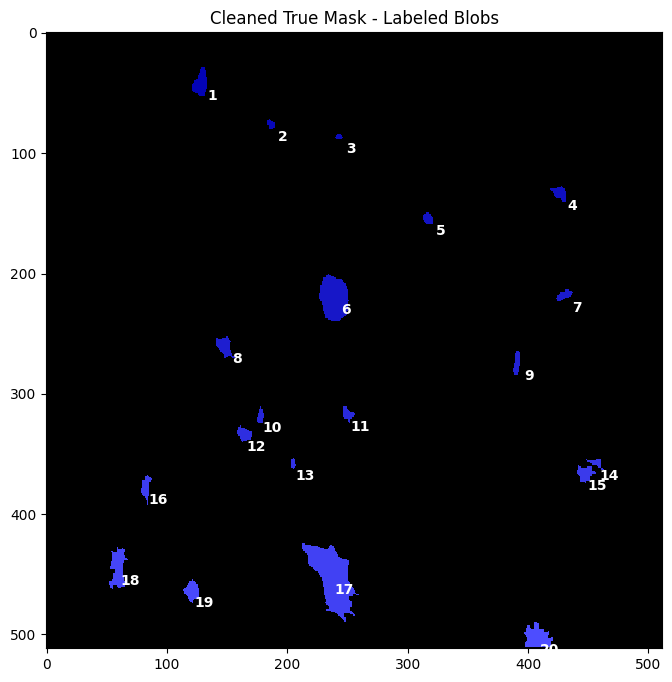

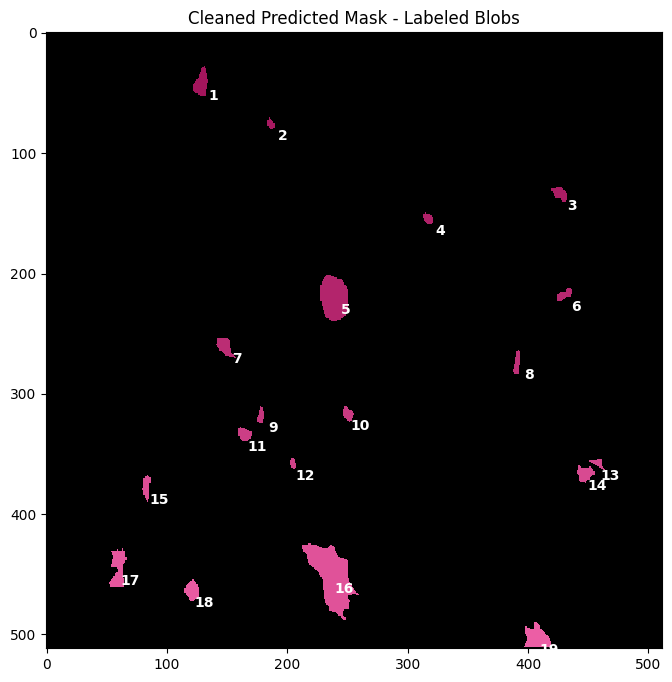

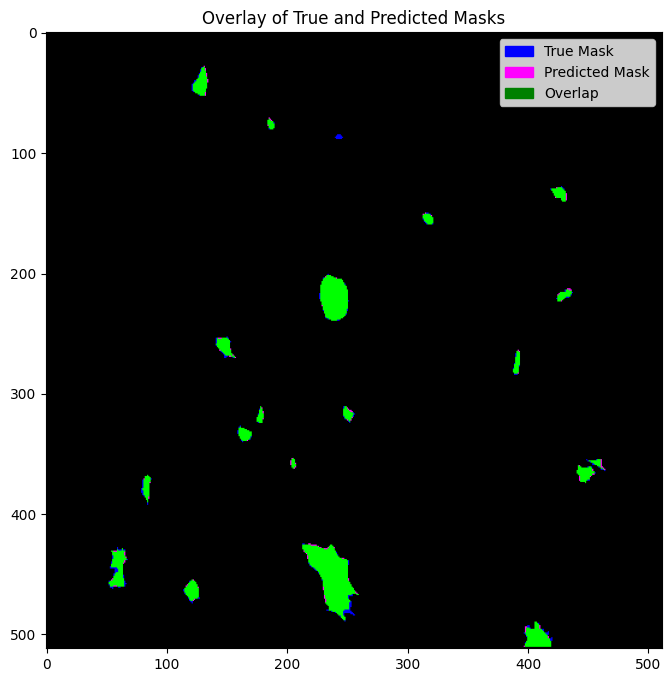

IoU Matrix:
              Predicted Blob 1  Predicted Blob 2  Predicted Blob 3  \
True Blob 1           0.861111          0.000000           0.00000   
True Blob 2           0.000000          0.863636           0.00000   
True Blob 3           0.000000          0.000000           0.00000   
True Blob 4           0.000000          0.000000           0.88785   
True Blob 5           0.000000          0.000000           0.00000   
True Blob 6           0.000000          0.000000           0.00000   
True Blob 7           0.000000          0.000000           0.00000   
True Blob 8           0.000000          0.000000           0.00000   
True Blob 9           0.000000          0.000000           0.00000   
True Blob 10          0.000000          0.000000           0.00000   
True Blob 11          0.000000          0.000000           0.00000   
True Blob 12          0.000000          0.000000           0.00000   
True Blob 13          0.000000          0.000000           0.00000   
True Blo

/tmp/ipykernel_32/447914404.py:280: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if mask_np.dtype != np.bool:
/tmp/ipykernel_32/447914404.py:284: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  resized_predictions_np = resized_predictions_np.astype(np.bool)


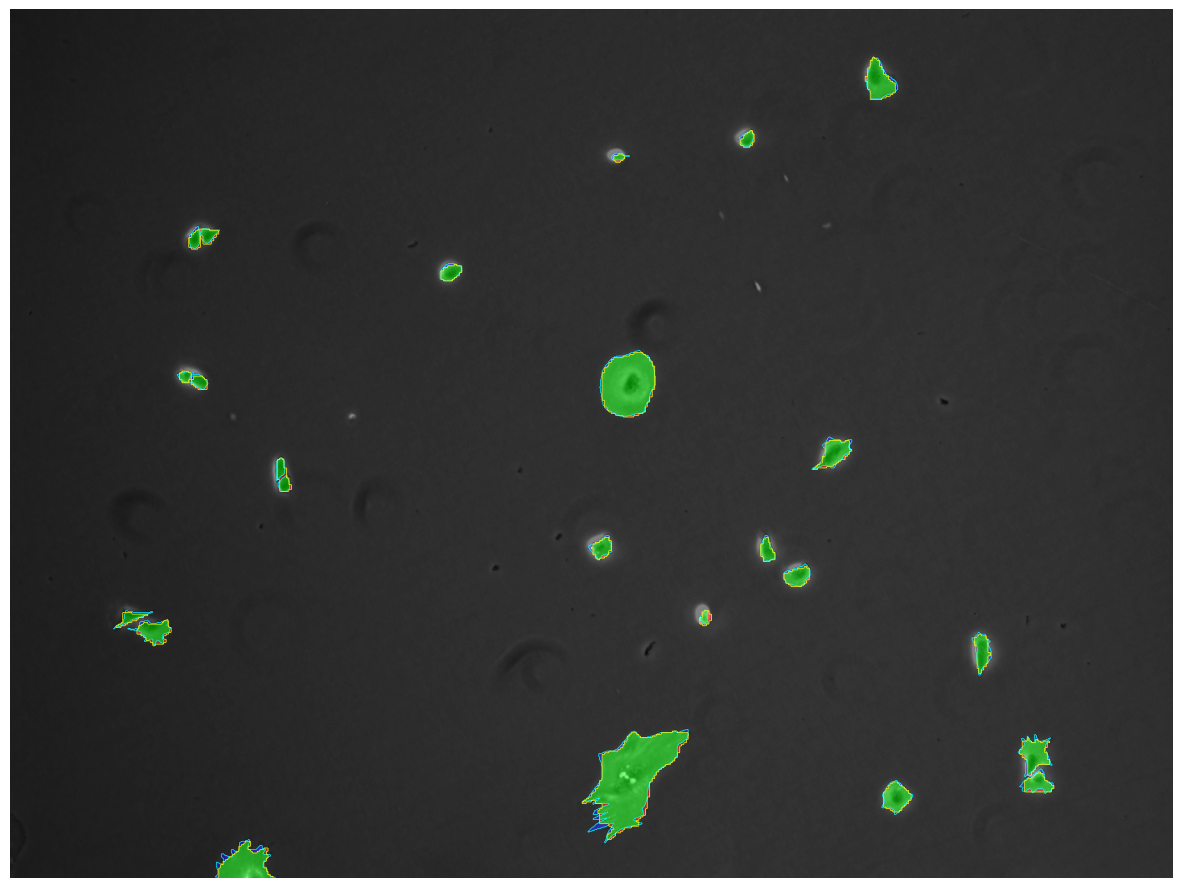

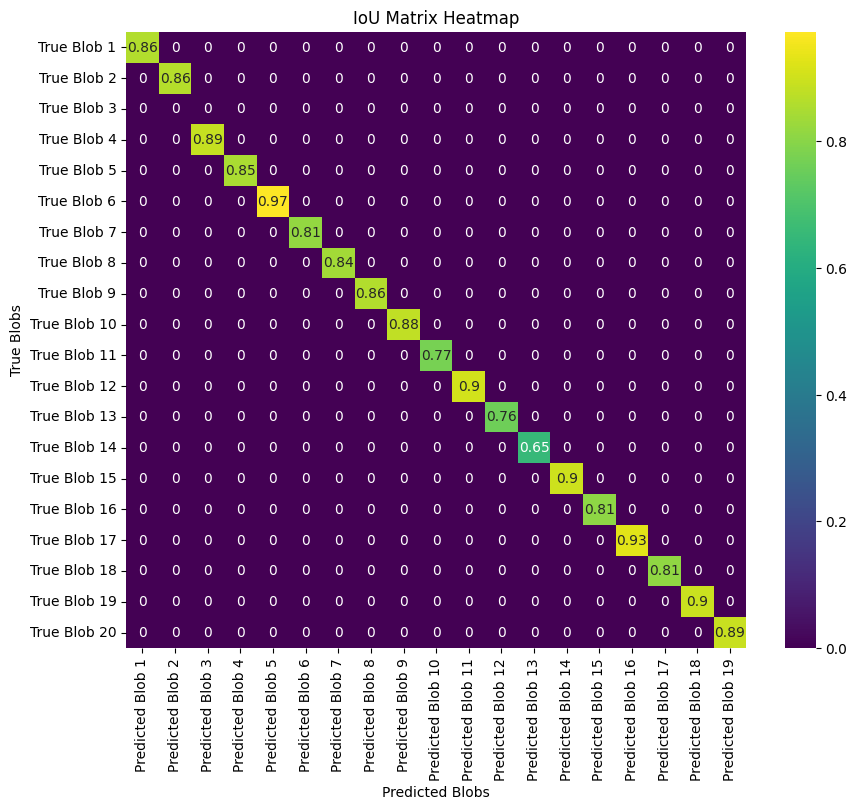

In [45]:
# Set the model to evaluation mode and load a batch of images
model.eval()
# Unpack the batch
original_images, original_masks,images_tuple, targets_tuple, image_paths, replay = batch

# Convert tuples of images and targets to lists and then stack to create batch tensors
images = torch.stack([image.to(device) for image in images_tuple])
targets = torch.stack([target.to(device) for target in targets_tuple])

# Forward pass through the model to get the outputs
with torch.no_grad():
    outputs = model(images)
    outputs = torch.sigmoid(outputs)
    outputs = outputs > 0.5
    outputs = outputs.float()

# Convert the tensors to numpy arrays for processing
targets_np = targets.cpu().numpy()
outputs_np = outputs.cpu().numpy()


# Squeeze to remove the channel dimension if it's 1
targets_np = targets_np.squeeze(1)
outputs_np = outputs_np.squeeze(1)

# Define a size threshold for the minimum number of pixels for detected blobs
# If size_threshold is set to 100, then any blob with fewer than 100 pixels will be discarded. 
# This is particularly useful for removing noise or small artifacts
size_threshold = 20

# Define a structural element for morphological operations
structure = np.ones((3, 3))

# Function to clean the mask and remove small objects
def clean_mask(mask, size_threshold):
    # Apply morphological closing to fill small holes
    closed_mask = ndi.binary_closing(mask, structure)
    # Label the objects
    labeled_mask, _ = ndi.label(closed_mask, structure=structure)
    # Remove small objects
    object_slices = ndi.find_objects(labeled_mask)
    for slice_ in object_slices:
        if slice_ is not None:
            object_mask = labeled_mask[slice_] > 0
            if np.sum(object_mask) < size_threshold:
                closed_mask[slice_][object_mask] = 0
    # Re-label the cleaned mask
    cleaned_mask, num_blobs = ndi.label(closed_mask, structure=structure)
    return cleaned_mask, num_blobs

# Clean the target and output masks
cleaned_targets, num_blobs_targets = clean_mask(targets_np[0] > 0.5, size_threshold)
cleaned_outputs, num_blobs_outputs = clean_mask(outputs_np[0] > 0.5, size_threshold)

# Display the number of blobs for true masks (targets) and predicted masks (outputs)
print("Number of cleaned blobs in true masks (targets):", num_blobs_targets)
print("Number of cleaned blobs in predicted masks (outputs):", num_blobs_outputs)






def plot_mask_with_uniform_color_and_numbers(labeled_mask, title, color):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title(title)

    # Plot the labeled mask with a uniform color
    ax.imshow(labeled_mask, cmap=plt.cm.gray, interpolation='none')  # Plot the mask in grayscale

    # Overlay the blobs with the specified color
    mask = labeled_mask > 0  # Blobs as 1, background as 0
    ax.imshow(np.ma.masked_where(mask == 0, mask), cmap=plt.cm.colors.ListedColormap([color]), interpolation='none', alpha=0.7)

    # Loop through each unique label, calculate an offset position, and put a text
    unique_labels = np.unique(labeled_mask)
    for label in unique_labels[1:]:  # Exclude the background label
        y, x = np.mean(np.argwhere(labeled_mask == label), axis=0)  # Get the centroid of the blob
        offset_x, offset_y = 10, 10  # Set an offset for the label position
        plt.text(x + offset_x, y + offset_y, str(label), color='white', ha='center', va='center', fontweight='bold')

    plt.show()

# Define colors for the true mask (blue) and the predicted mask (magenta-like color)
true_mask_color = 'blue'
# Use an RGB tuple that resembles the color from your image
predicted_mask_color = (0.9, 0.1, 0.5)  # This is a magenta-like color

# Use the updated plotting function to display the true and predicted masks
plot_mask_with_uniform_color_and_numbers(cleaned_targets, 'Cleaned True Mask - Labeled Blobs', true_mask_color)
plot_mask_with_uniform_color_and_numbers(cleaned_outputs, 'Cleaned Predicted Mask - Labeled Blobs', predicted_mask_color)














import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import measure


def visualize_blobs(true_mask, pred_mask, title):
    # Ensure the masks are 2D
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask)
    
    # Find connected components (blobs) in the true and predicted masks
    true_labels = measure.label(true_mask)
    pred_labels = measure.label(pred_mask)
    
    # Create an overlay image
    overlay_img = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)
    
    # Overlay true mask in blue
    overlay_img[true_labels > 0, 2] = 255  # Blue channel
    
    # Overlay predicted mask in magenta
    magenta = [255, 0, 255]  # RGB for magenta
    for i in range(3):
        overlay_img[pred_labels > 0, i] = np.maximum(overlay_img[pred_labels > 0, i], magenta[i])
    
    # Define overlap: where both true and predicted masks are positive
    overlap = (true_labels > 0) & (pred_labels > 0)
    overlay_img[overlap, :] = [0, 255, 0]  # RGB for green
    
    fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure size for better visibility
    ax.imshow(overlay_img)
    plt.title(title)
    
    # Create a legend for the colors used in the overlay
    legend_labels = [mpatches.Patch(color='blue', label='True Mask'),
                     mpatches.Patch(color='magenta', label='Predicted Mask'),
                     mpatches.Patch(color='green', label='Overlap')]
    
    # Add the legend to the plot
    ax.legend(handles=legend_labels, loc='upper right')
    
    plt.show()

# Visualize blobs for the first image in the batch
visualize_blobs(cleaned_targets, cleaned_outputs, 'Overlay of True and Predicted Masks')











# Convert numpy arrays to tensors
def convert_to_tensor(mask):
    return torch.from_numpy(mask).type(torch.LongTensor)

# Function to calculate IoU using torchmetrics for individual blobs, excluding the background
def calculate_iou_for_blobs(mask_true, mask_pred):
    iou_calculator = torchmetrics.JaccardIndex(task='binary',num_classes=mask_true.max() + 1)
    unique_labels_true = mask_true.unique()[1:]  # Exclude background
    unique_labels_pred = mask_pred.unique()[1:]  # Exclude background

    iou_matrix = np.zeros((len(unique_labels_true), len(unique_labels_pred)))

    for i, label_true in enumerate(unique_labels_true):
        for j, label_pred in enumerate(unique_labels_pred):
            # Create binary masks for each blob
            binary_mask_true = (mask_true == label_true).long()
            binary_mask_pred = (mask_pred == label_pred).long()

            # Calculate IoU for the blob pair
            iou_matrix[i, j] = iou_calculator(binary_mask_true, binary_mask_pred).item()

    return iou_matrix

# Convert masks to tensors
cleaned_targets_tensor = convert_to_tensor(cleaned_targets)
cleaned_outputs_tensor = convert_to_tensor(cleaned_outputs)

# Calculate the IoU matrix using torchmetrics for each blob pair
iou_matrix = calculate_iou_for_blobs(cleaned_targets_tensor, cleaned_outputs_tensor)


# Create row and column labels based on the unique labels
row_labels = [f'True Blob {i}' for i in range(1, num_blobs_targets + 1)]
column_labels = [f'Predicted Blob {i}' for i in range(1, num_blobs_outputs + 1)]


# Create the DataFrame with the correct row and column labels
iou_df = pd.DataFrame(iou_matrix, index=row_labels, columns=column_labels)

print("IoU Matrix:")
print(iou_df)










single_image = images_tuple[0].unsqueeze(0)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Switch the model to evaluation mode
model.eval()

# Move the image tensor to the same device as the model
single_image = single_image.to(device)

# Perform the forward pass to get predictions
with torch.no_grad():
    predictions = model(single_image)
    predictions = predictions.sigmoid()
    predictions_binary_mask = predictions > 0.5

# Convert the binary predictions to CPU and detach from the graph
predictions_binary_np = predictions_binary_mask.cpu().detach().numpy().squeeze()

# Resize the prediction to the original image size
original_size = (1040, 1392)  # The original image size
# Interpolate the prediction mask to the original image size
resized_predictions = F.interpolate(predictions_binary_mask.float(), size=original_size, mode='nearest')

# Check and apply horizontal flip if it was applied during augmentation
def was_image_flipped(replay_info):
    for transform in replay_info.get('transforms', []):
        if transform.get('__class_fullname__', "") == 'HorizontalFlip':
            return transform.get('applied', False)
    return False

flip_status = was_image_flipped(replay[0])
if flip_status:
    resized_predictions = torch.flip(resized_predictions, [3])  # Flipping horizontally along width

# Convert the resized prediction mask to a numpy array
resized_predictions_np = resized_predictions.squeeze(0).squeeze(0).cpu().numpy()  # Removing batch and channel dims

    
print(replay[0])
print("Was the image flipped? ", flip_status)
    
# Set transparency levels for the true and predicted masks
true_mask_alpha = 0.1  # Adjust this value for the true mask transparency
predicted_mask_alpha = 0.1  # Adjust this value for the predicted mask transparency


# Set up the figure with a specified size
plt.figure(figsize=(15, 15))

# Convert the original image to numpy for display and normalize if necessary
image_np = original_images[0].cpu().detach().numpy().squeeze()
if image_np.ndim == 3:
    image_np = image_np.transpose(1, 2, 0)
if image_np.max() > 1.0:
    image_np = image_np.astype(np.float32) / 255.

# Display the original image
plt.imshow(image_np, cmap='gray')

# Overlay the true mask with adjustable transparency
mask_np = original_masks[0].cpu().detach().numpy().squeeze()
if mask_np.dtype != np.bool:
    mask_np = mask_np > 0

# Ensure that the prediction mask is boolean
resized_predictions_np = resized_predictions_np.astype(np.bool)

# Create an overlay image
overlay_image = np.zeros((*mask_np.shape, 3), dtype=np.uint8)

# Set true mask to blue
overlay_image[mask_np] = [0, 0, 255]

# Set predicted mask to red
overlay_image[resized_predictions_np] = [255, 0, 0]

# Set overlaps to green
overlay_image[(mask_np) & (resized_predictions_np)] = [0, 255, 0]

# Display the overlay
plt.imshow(overlay_image, alpha=0.5)

# Draw contours around the true mask if needed
if true_mask_alpha > 0:
    plt.contour(mask_np, colors='cyan', levels=[0.5], linewidths=0.5)

# Draw contours around the predicted mask if needed
if predicted_mask_alpha > 0:
    plt.contour(resized_predictions_np, colors='yellow', levels=[0.5], linewidths=0.5)

# Hide the axes
plt.axis('off')

# Show the plot with the overlay
plt.show()

# heatmap

# Create the DataFrame with the correct row and column labels
iou_df = pd.DataFrame(iou_matrix, index=row_labels, columns=column_labels)

# Set the size of the matplotlib canvas
plt.figure(figsize=(10, 8))

# Create the heatmap
# Using seaborn for enhanced visualization (optional)
sns.heatmap(iou_matrix, annot=True, cmap='viridis', 
            xticklabels=column_labels, yticklabels=row_labels)

# Alternatively, using matplotlib's imshow function
# plt.imshow(iou_matrix, cmap='viridis', interpolation='nearest')
# plt.colorbar()  # To add a color bar

# Adding axis labels and title
plt.xlabel('Predicted Blobs')
plt.ylabel('True Blobs')
plt.title('IoU Matrix Heatmap')

# Show the plot
plt.show()


IoU Matrix:
              Predicted Blob 1  Predicted Blob 2  Predicted Blob 3  \
True Blob 1           0.861111          0.000000           0.00000   
True Blob 2           0.000000          0.863636           0.00000   
True Blob 3           0.000000          0.000000           0.00000   
True Blob 4           0.000000          0.000000           0.88785   
True Blob 5           0.000000          0.000000           0.00000   
True Blob 6           0.000000          0.000000           0.00000   
True Blob 7           0.000000          0.000000           0.00000   
True Blob 8           0.000000          0.000000           0.00000   
True Blob 9           0.000000          0.000000           0.00000   
True Blob 10          0.000000          0.000000           0.00000   
True Blob 11          0.000000          0.000000           0.00000   
True Blob 12          0.000000          0.000000           0.00000   
True Blob 13          0.000000          0.000000           0.00000   
True Blo

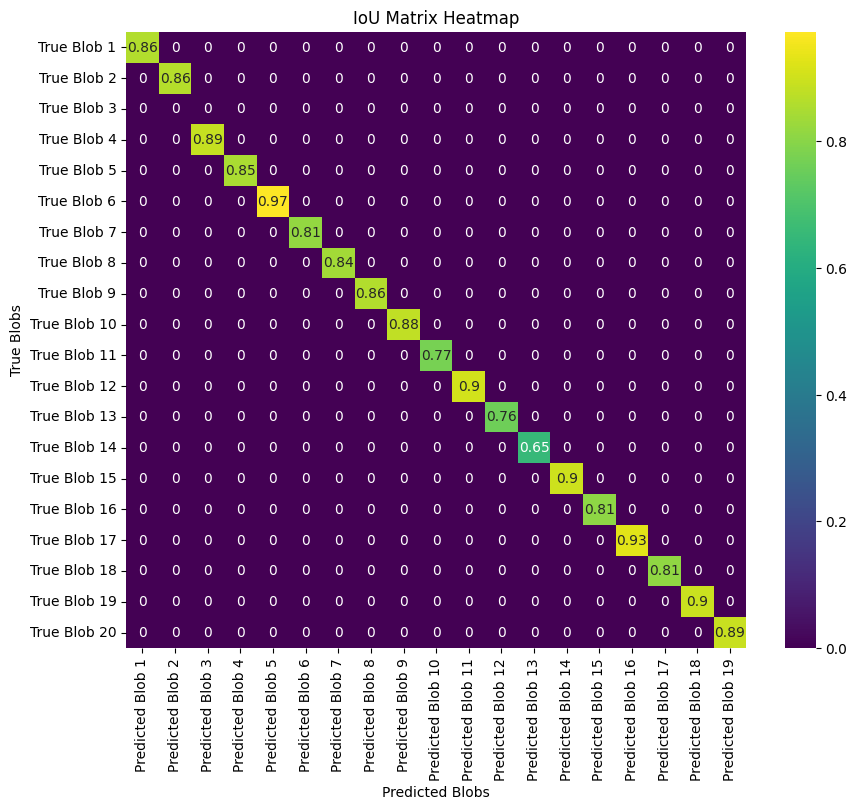

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns  
import pandas as pd  



# Create the DataFrame with the correct row and column labels
iou_df = pd.DataFrame(iou_matrix, index=row_labels, columns=column_labels)

# Print the IoU Matrix DataFrame
print("IoU Matrix:")
print(iou_df)

# Set the size of the matplotlib canvas
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(iou_matrix, annot=True, cmap='viridis', 
            xticklabels=column_labels, yticklabels=row_labels)


# Adding axis labels and title
plt.xlabel('Predicted Blobs')
plt.ylabel('True Blobs')
plt.title('IoU Matrix Heatmap')

# Show the plot
plt.show()


/tmp/ipykernel_32/214783155.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if mask_np.dtype != np.bool:
/tmp/ipykernel_32/214783155.py:83: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  resized_predictions_np = resized_predictions_np.astype(np.bool)


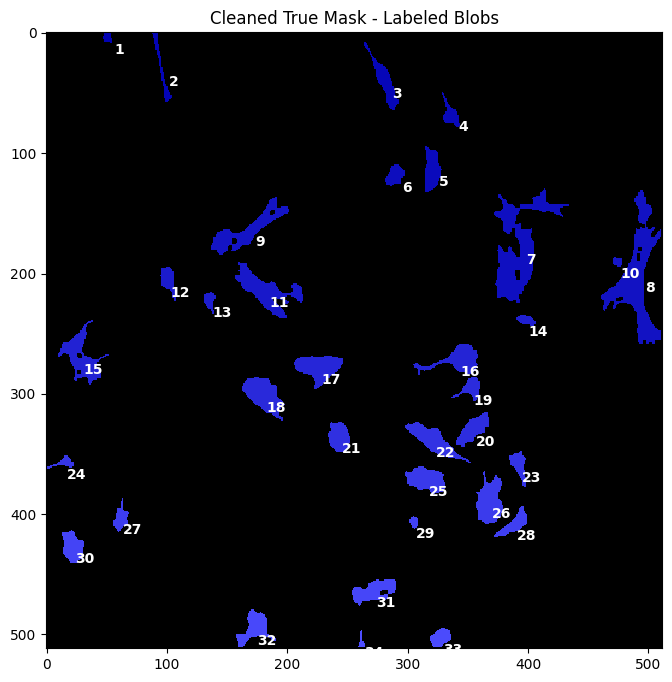

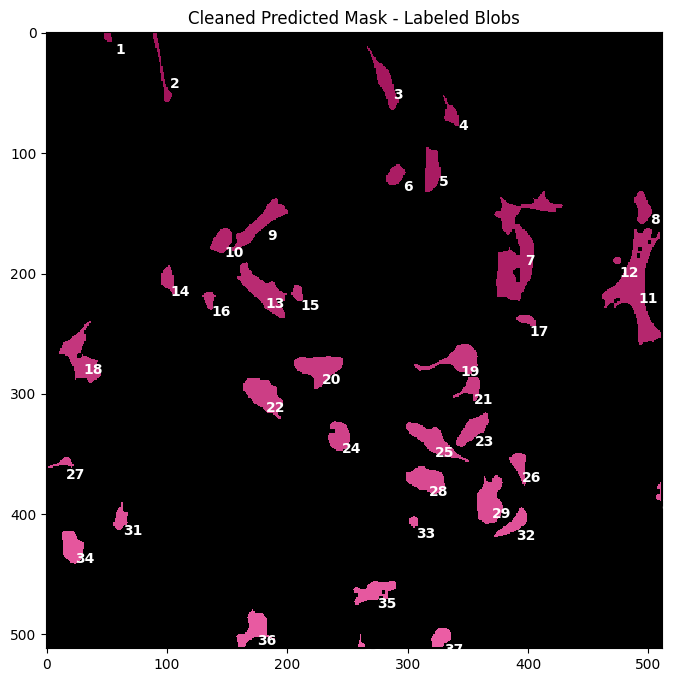

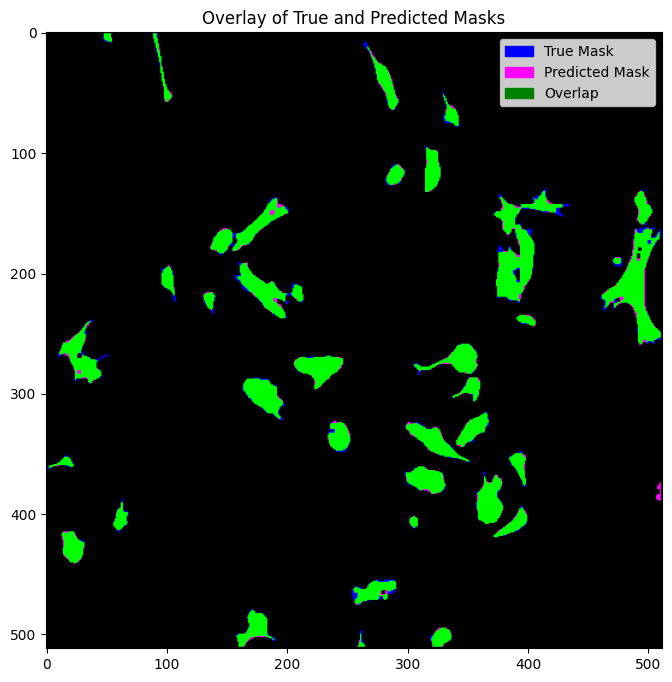

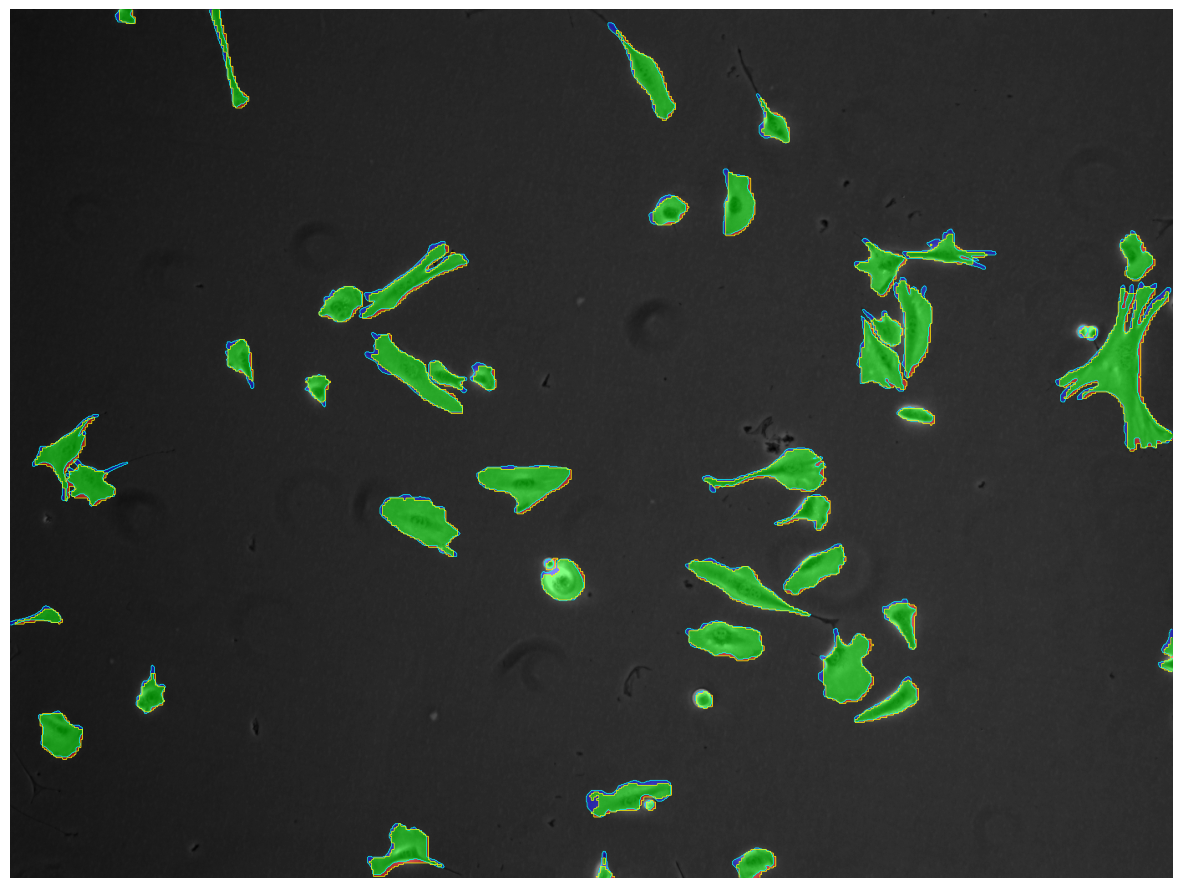

In [109]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import measure
import pandas as pd
import torchmetrics
import scipy.ndimage as ndi


# Define a function to save the plot
def save_plot(fig, filename):
    fig.savefig(f'/kaggle/working/{filename}.png')

# Updated plot_mask_with_uniform_color_and_numbers function
def plot_mask_with_uniform_color_and_numbers(labeled_mask, title, color, filename):
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title(title)

    # Plot the labeled mask with a uniform color
    ax.imshow(labeled_mask, cmap=plt.cm.gray, interpolation='none')
    mask = labeled_mask > 0
    ax.imshow(np.ma.masked_where(mask == 0, mask), cmap=plt.cm.colors.ListedColormap([color]), interpolation='none', alpha=0.7)

    unique_labels = np.unique(labeled_mask)
    for label in unique_labels[1:]:
        y, x = np.mean(np.argwhere(labeled_mask == label), axis=0)
        offset_x, offset_y = 10, 10
        plt.text(x + offset_x, y + offset_y, str(label), color='white', ha='center', va='center', fontweight='bold')

    save_plot(fig, filename)  # Save the figure

# Plot and save true and predicted masks
plot_mask_with_uniform_color_and_numbers(cleaned_targets, 'Cleaned True Mask - Labeled Blobs', true_mask_color, 'true_mask_labeled')
plot_mask_with_uniform_color_and_numbers(cleaned_outputs, 'Cleaned Predicted Mask - Labeled Blobs', predicted_mask_color, 'predicted_mask_labeled')

# Updated visualize_blobs function
def visualize_blobs(true_mask, pred_mask, title, filename):
    true_mask = np.squeeze(true_mask)
    pred_mask = np.squeeze(pred_mask)
    true_labels = measure.label(true_mask)
    pred_labels = measure.label(pred_mask)

    overlay_img = np.zeros((true_mask.shape[0], true_mask.shape[1], 3), dtype=np.uint8)
    overlay_img[true_labels > 0, 2] = 255

    magenta = [255, 0, 255]
    for i in range(3):
        overlay_img[pred_labels > 0, i] = np.maximum(overlay_img[pred_labels > 0, i], magenta[i])

    overlap = (true_labels > 0) & (pred_labels > 0)
    overlay_img[overlap, :] = [0, 255, 0]

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(overlay_img)
    plt.title(title)
    legend_labels = [mpatches.Patch(color='blue', label='True Mask'),
                     mpatches.Patch(color='magenta', label='Predicted Mask'),
                     mpatches.Patch(color='green', label='Overlap')]
    ax.legend(handles=legend_labels, loc='upper right')

    save_plot(fig, filename)  # Save the figure

# Visualize and save blobs for the first image in the batch
visualize_blobs(cleaned_targets, cleaned_outputs, 'Overlay of True and Predicted Masks', 'overlay_true_predicted_masks')


# Final plotting section (Overlay of masks)
plt.figure(figsize=(15, 15))
image_np = original_images[0].cpu().detach().numpy().squeeze()
if image_np.ndim == 3:
    image_np = image_np.transpose(1, 2, 0)
if image_np.max() > 1.0:
    image_np = image_np.astype(np.float32) / 255.

plt.imshow(image_np, cmap='gray')
mask_np = original_masks[0].cpu().detach().numpy().squeeze()
if mask_np.dtype != np.bool:
    mask_np = mask_np > 0
resized_predictions_np = resized_predictions_np.astype(np.bool)

overlay_image = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
overlay_image[mask_np] = [0, 0, 255]
overlay_image[resized_predictions_np] = [255, 0, 0]
overlay_image[(mask_np) & (resized_predictions_np)] = [0, 255, 0]

plt.imshow(overlay_image, alpha=0.5)
if true_mask_alpha > 0:
    plt.contour(mask_np, colors='cyan', levels=[0.5], linewidths=0.5)
if predicted_mask_alpha > 0:
    plt.contour(resized_predictions_np, colors='yellow', levels=[0.5], linewidths=0.5)

plt.axis('off')
plt.savefig('/kaggle/working/mask_overlay.png')  # Save the final overlay image
plt.show()
